In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
print("数据基本信息：")

数据基本信息：


In [4]:
print(f"形状：{df.shape}行 x {df.columns.tolist()}列")

形状：(541909, 8)行 x ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']列


In [5]:
print("前5行：")
print(df.head())

前5行：
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [6]:
print("\n数据类型：")
print(df.dtypes)


数据类型：
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [8]:
plt.rcParams['font.sans-serif']=['SimHei']#中文显示

In [9]:
plt.rcParams['axes.unicode_minus']=False

In [10]:
os.makedirs('reports',exist_ok=True)#自动创建目录

In [11]:
df = pd.read_excel('Online Retail.xlsx',sheet_name=0)

In [12]:
print(f"\n清洗前:{df.shape[0]:,}行")#开始数据清洗


清洗前:541,909行


In [13]:
df = df.dropna(subset=['CustomerID'])#删除缺少客户ID

In [14]:
df=df[(df['Quantity']>0)&(df['UnitPrice']>0)]#删除退货数据

In [15]:
df['CustomerID']=df['CustomerID'].astype(int)#确保ID为整数

In [16]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])#转换日期

In [17]:
print(f"清洗后：{df.shape[0]:,}行")

清洗后：397,884行


In [18]:
df['Amount']=df['Quantity']*df['UnitPrice']#创建金额列，金额=数量X单价

In [19]:
df.to_csv('Online_Retail_Cleaned.csv',index=False)#将清洗后的数据保存为一个新的csv

In [20]:
snapshot_date=df['InvoiceDate'].max()+pd.Timedelta(days=1)#设定快照日（数据集最后一天+1天）
print(f"分析截止日期：{snapshot_date.strftime('%Y-%m—%d')}")

分析截止日期：2011-12—10


In [21]:
rfm = df.groupby('CustomerID').agg({'InvoiceDate':lambda x:(snapshot_date - x.max()).days,#Recency
                                    'InvoiceNo':'nunique',#Frequency:订单数，不是商品行数
                                   'Amount':'sum'#Monetart
                                   })

In [22]:
rfm.rename(columns={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'Amount':'Monetary'
},inplace=True)

In [23]:
print("\nRFM计算结果示例：")
print(rfm.head())
print(f"\n客户总数：{len(rfm):,}人")


RFM计算结果示例：
            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40

客户总数：4,338人


In [24]:
#用qcut做五份位打分
rfm['R_Score']=pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1])
rfm['F_Score']=pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score']=pd.qcut(rfm['Monetary'],5,labels=[1,2,3,4,5])

In [25]:
rfm['RFM_Score']=rfm['R_Score'].astype(int)+rfm['F_Score'].astype(int)+rfm['M_Score'].astype(int)#计算总分

In [37]:
def segment_rfm(row): #rfm分层
    r,f,m=row['R_Score'],row['F_Score'],row['M_Score']
    if r>=4 and f>=4 and m>=4:
        return 'VIP'
    elif r>=3 and f>=3 and m>=3:
        return 'Loyal'
    elif r>=4 and f<=2:
        return 'New'
    elif r<=2 and f>=3:
        return 'At Risk'
    elif r<=2 and f<=2:
        return 'Lost'
    else:
        return 'Potential'

In [38]:
rfm['Segment']=rfm.apply(segment_rfm,axis=1)

In [39]:
rfm.to_csv('reports/rfm_results.csv')

In [40]:
print("\n客户分层完成，分布如下：")
print(rfm['Segment'].value_counts())


客户分层完成，分布如下：
Segment
Lost         1065
VIP           962
Loyal         758
At Risk       643
Potential     591
New           319
Name: count, dtype: int64


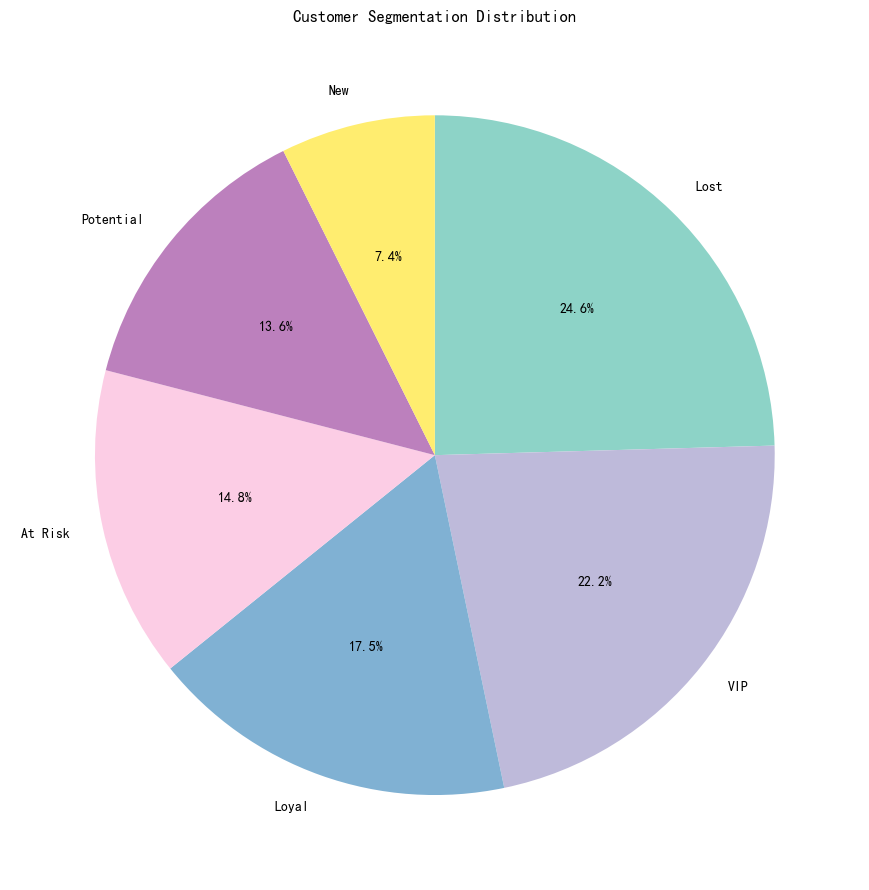

In [41]:
#客户分层饼图
plt.figure(figsize=(10,9))
rfm['Segment'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    cmap='Set3',
    title='Customer Segmentation Distribution'
)
plt.ylabel('')
plt.tight_layout()
plt.savefig('reports/segment_pie.png',dpi=300,
           bbox_inches='tight')
plt.show()

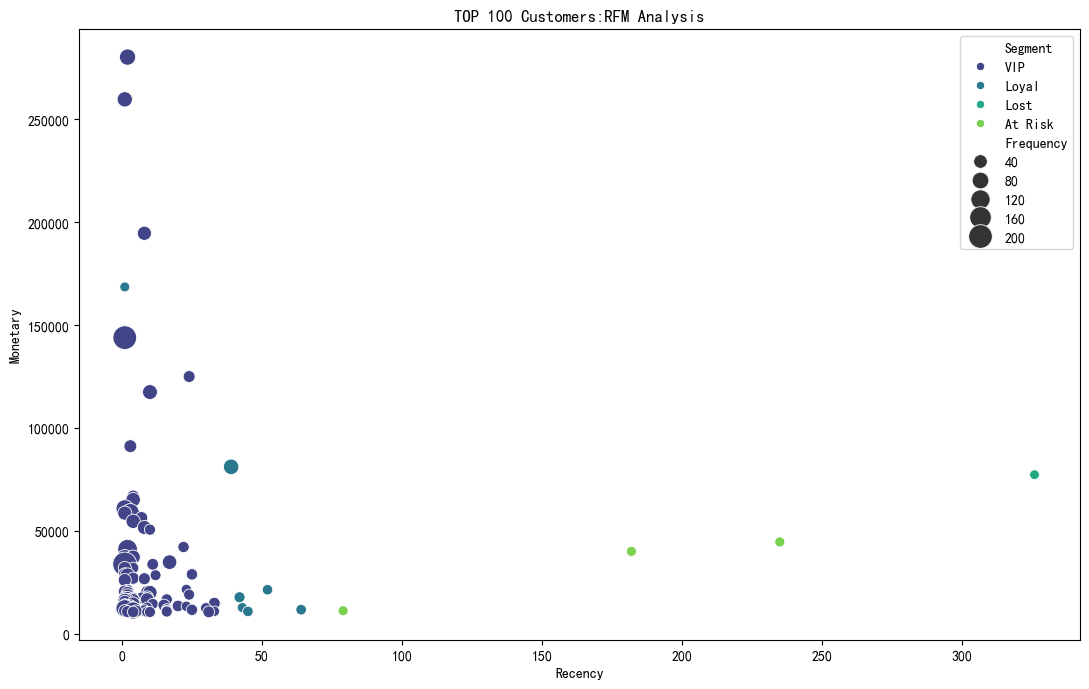

In [42]:
#Top100客户RFM散点图
top100=rfm.nlargest(100,'Monetary')
plt.figure(figsize=(11,7))
sns.scatterplot(
    data=top100,
    x='Recency',
    y='Monetary',
    hue='Segment',
    size='Frequency',
    sizes=(50,300),
    palette='viridis'
)
plt.title('TOP 100 Customers:RFM Analysis')
plt.tight_layout()
plt.savefig('reports/top100_scatter.png',dpi=300,bbox_inches='tight')
plt.show()

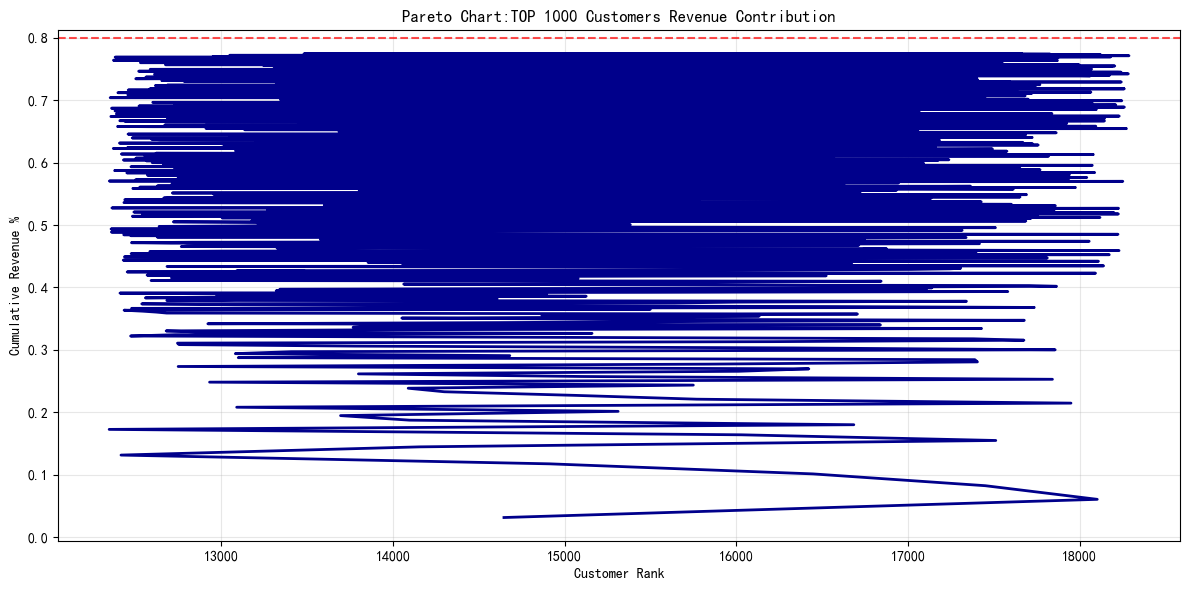

In [44]:
#应收贡献帕累托图
rfm_sorted = rfm.sort_values('Monetary',ascending=False)
rfm_sorted['Cumulative_Revenue']=rfm_sorted['Monetary'].cumsum()
rfm_sorted['Cumulative_Pct']=rfm_sorted['Cumulative_Revenue']/rfm_sorted['Monetary'].sum()
plt.figure(figsize=(12,6))
plt.plot(rfm_sorted['Cumulative_Pct'][:1000],linewidth=2,color='darkblue')
plt.axhline(y=0.8,color='r',linestyle='--',alpha=0.7)
plt.title('Pareto Chart:TOP 1000 Customers Revenue Contribution')
plt.xlabel('Customer Rank')
plt.ylabel('Cumulative Revenue %')
plt.grid(True,alpha=0.3)
plt.tight_layout()
plt.savefig('reports/pareto_chart.png',dpi=300,bbox_inches='tight')
plt.show()

In [45]:
#计算关键指标
VIP = rfm[rfm['Segment'] == 'VIP']
lost = rfm[rfm['Segment'] == 'Lost']
print(f"VIP客户：{len(VIP)}人，贡献${VIP['Monetary'].sum():,.2f}(占比{VIP['Monetary'].sum()/rfm['Monetary'].sum()*100:.1f}%)")

VIP客户：962人，贡献$5,809,341.07(占比65.2%)


In [46]:
print(f"流失客户：{len(lost)}人，需召回价值${lost['Monetary'].sum():,.2f}")
print(f"平均客单价：${rfm['Monetary'].mean():.2f}")
print(f"RFM分数中位数：{rfm['RFM_Score'].median()}")

流失客户：1065人，需召回价值$519,408.57
平均客单价：$2054.27
RFM分数中位数：9.0


In [47]:
#各层客户均值
print("\n各层级客户平均指标：")
segment_stats = rfm.groupby('Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
}).round(2)
print(segment_stats)


各层级客户平均指标：
          Recency Frequency Monetary      
             mean      mean     mean count
Segment                                   
At Risk    152.84      3.40  1244.99   643
Lost       217.90      1.10   487.71  1065
Loyal       35.69      4.13  1842.60   758
New         18.52      1.24   458.20   319
Potential   43.57      1.67   404.85   591
VIP         12.86     11.08  6038.82   962
